<a href="https://colab.research.google.com/github/albreyes/PE-A-09/blob/main/solucionTareas1_2_multiPasos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Pronóstico univariado a multiples pasos usando LSTM 

En este ejercicio aprenderemos a utilizar python para crear un modelo de pronóstico para una serie de datos de demanda eléctrica anual. La entrada será una serie de tres pasos. El pronóstico tendrá dos pasos en adelanto y los resultados se presentarán paso por paso. El paso de tiempo (timestep) tanto en la entrada como en la salida será de un año. Como técnica de aprendizaje utilizaremos una red LSTM apilada (stacked)



## Preparación de los datos

Antes de pasar a la construcción del modelo se deben preparar los datos. Al igual que con el pronóstico de un paso, una serie de tiempo utilizada para el pronóstico de series de varios pasos debe dividirse en muestras con componentes de entrada y salida.

Tanto los componentes de entrada como los de salida estarán compuestos por múltiples pasos de tiempo y pueden tener o no el mismo número de pasos.

Por ejemplo, dada la serie de tiempo univariada:

\\begin{matrix}[10 & 20 & 30 & 40 & 50 & 60 & 70 & 80 & 90 ]\\\end{matrix}

Podríamos usar los últimos tres pasos de tiempo como entrada y pronosticar los dos próximos pasos de tiempo.

La primera muestra se vería de la siguiente manera:

Entrada:

\\begin{matrix}[10 & 20 & 30 ]\\\end{matrix}

Salida:


\\begin{matrix}[40 & 50 ]\\\end{matrix}

La función split_sequence() siguiente implementa este comportamiento dividiendo una serie de tiempo univariada en muestras con un número específico de pasos de tiempo de entrada y salida.

In [76]:
# univariate multi-step vector-output stacked lstm example
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

Podemos demostrar esta función con el conjunto de datos de ejemplo.

In [77]:
# definimos secuancia de entrada 
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# escogemos un número de pasos de entrada y salida 
n_steps_in, n_steps_out = 3, 2
# dividimos en ejemplos X , y
X, y = split_sequence(raw_seq, n_steps_in, n_steps_out)
# visualizamos los resultados
for i in range(len(X)):
	print(X[i], y[i])

[10 20 30] [40 50]
[20 30 40] [50 60]
[30 40 50] [60 70]
[40 50 60] [70 80]
[50 60 70] [80 90]


La ejecución del ejemplo divide la serie univariada  en pasos de tiempo de entrada y salida e imprime los componentes de entrada y salida de cada uno.

Ahora que sabemos cómo preparar datos para el pronóstico de varios pasos, veamos como construir una red LSTM tipo output vector model.

Al igual que otros tipos de modelos de redes neuronales, el LSTM puede generar un vector directamente que se puede interpretar como un pronóstico de varios pasos.

Al igual que con los LSTM para datos univariados de la sección anterior, primero se deben remodelar (reshape) las muestras preparadas. El LSTM espera que los datos tengan una estructura tridimensional de la forma: [***muestras, intervalos de tiempo, características***] y, como en este caso solo tenemos una característica,  la remodelación es muy sencilla. Veamos como cambia el formato para el conjunto de entradas:

In [78]:
print('Antes',X)
# remodela de [muestras, timesteps] a [muestras, timesteps, características]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
print('Después',X)

Antes [[10 20 30]
 [20 30 40]
 [30 40 50]
 [40 50 60]
 [50 60 70]]
Después [[[10]
  [20]
  [30]]

 [[20]
  [30]
  [40]]

 [[30]
  [40]
  [50]]

 [[40]
  [50]
  [60]]

 [[50]
  [60]
  [70]]]


#Solución tarea 1

1. Preparar los datos en forma de una serie de tiempo univariada y guardarla en drive.

Usemos el conjunto de datos de demanda máxima mensual de temporada de invierno en una SE de CFE con datos promedio anual durante 8 inviernos (archivo:  datosSE-CFE.xlsx).

Arreglar los datos de invierno en una sola columna DMM, guardarla en formato cvs con otro nombre, por ejemplo datosSE-CFE-invierno-TS.csv y subirla al directorio "../Colab Notebooks" de su unidad en google drive.

2.	Cargar los datos desde drive.

Para esto, montar la unidad en drive y guardar los datos en la variable raw_seq.

In [79]:
# montamos la unidad de drive en colab
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [80]:
import csv
import numpy as np

# el archivo resultante en formato csv se renombro como datosSE-CFE-invierno-TS.csv.
data_path= 'gdrive/My Drive/Colab Notebooks/datosSE-CFE-invierno-TS.csv'

with open(data_path, 'r') as f:
    reader = csv.reader(f, delimiter=',')
    headers = next(reader)
    raw_seq = np.array(list(reader)).astype(float)
    raw_seq = [row[0] for row in raw_seq]

print(raw_seq)

[6.25, 6.25, 6.25, 7.93, 7.94, 6.66, 6.93, 6.69, 8.04, 15.41, 9.23, 9.09, 11.7, 9.8, 10.11, 13.4, 11.72, 10.86, 11.06, 10.93, 11.62, 17.32, 14.56, 11.64, 11.64, 12.04, 14.28, 17.64, 16.88, 14.16, 13.4, 13.92, 15.64, 20.64, 23.04, 23.04, 21.48, 20.88, 21.36, 24.36, 20.04, 17.52, 14.88, 16.2, 20.8, 24.72, 20.3, 18.0]


3.	Visualizar los datos de demanda máxima mensual (DMM) de toda la serie univariada.

Usar la función plot de la librería matplotlib para visualizr los datos de la serie de tiempo.

Text(0, 0.5, 'Demanda máxima mensual (MW)')

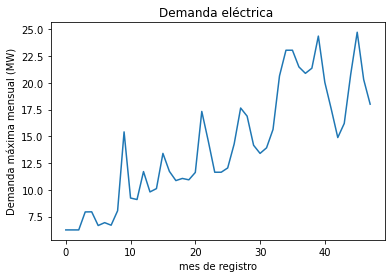

In [81]:
import matplotlib.pyplot as plt

plt.title('Demanda eléctrica ')
plt.plot(raw_seq)
plt.xlabel('mes de registro')
plt.ylabel('Demanda máxima mensual (MW)')

# Solución Tarea 2

1.	Construir un modelo LSTM para pronosticar 2 meses en adelanto en pasos de un mes dada una secuencia de 3 observaciones de entrada.

Con el número de pasos de entrada y salida especificados en las variables *n_steps_in* y *n_steps_out*, podemos definir un modelo de pronóstico de series de tiempo de dos pasos dada una secuencia de tres observaciones.

Se puede utilizar cuaquier topolgía de modelo LSTM, como Vanilla, Stacked, Bidirectional, CNN-LSTM o ConvLSTM. A continuación se define un LSTM apilado (stacked) para el pronóstico a  dos pasos (2 meses).

En cada celda LSTM se define su tipo de activación, optimizador y función de pérdida (generalmente MSE) para cáculo del error.

In [82]:
# escoger el número de pasos de timpo (time steps)
n_steps_in, n_steps_out = 3,2
# separar en muestras (preparación)
X, y = split_sequence(raw_seq, n_steps_in, n_steps_out)
# remodelación del formato [muestras, timesteps] a [muestras, timesteps, características]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
# definición del modelo LSTM apilado
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=1050, verbose=0)


Mostramos en forma de tabla y con una imágen información de la red LSTM construida (modelo).

In [83]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 3, 100)            40800     
_________________________________________________________________
lstm_13 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 202       
Total params: 121,402
Trainable params: 121,402
Non-trainable params: 0
_________________________________________________________________


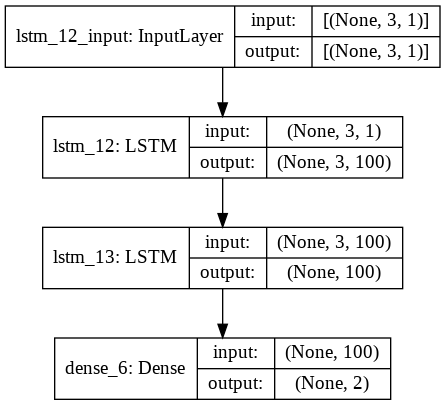

In [84]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='gdrive/My Drive/Colab Notebooks/model_tarea2.png', show_shapes=True, show_layer_names=True)

Y hacemos una demostracón de la predicción. Aquí seleccionamos aleatorimanente un vector de entrada, calculamos su pronóstico y lo comparamos con el vector de salida real (conocido). Para facilitar la lectura, graficamos la salida real contra la pronosticada (línea punteada verde).

secuencia de entrada: [13.4  11.72 10.86]
secuencia de salida (predicha): [11.176052 11.179105]
secuencia de salida (real): [11.06 10.93]


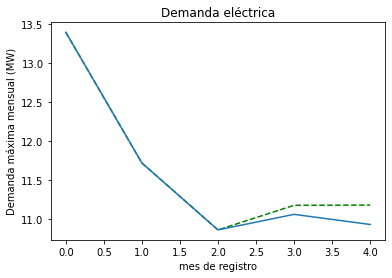

In [85]:
# demonstrate prediction
l=X.reshape((X.shape[0],X.shape[1]))
i_sample = np.random.randint(len(y))   # Tomar un ejemplo aleatorio
x_sample = l[i_sample]
x_sample = x_sample.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_sample, verbose=0)
print('secuencia de entrada:',l[i_sample])
print('secuencia de salida (predicha):',yhat[0])
print('secuencia de salida (real):',y[i_sample])

trama_real=np.append(l[i_sample],y[i_sample])
trama_predicha=np.append(l[i_sample],yhat[0])
plt.title('Demanda eléctrica')
plt.xlabel('mes de registro')
plt.ylabel('Demanda máxima mensual (MW)')
plt.plot(trama_predicha,color='green', linestyle='dashed')
plt.plot(trama_real)

2.	Comentar la gráfica de datos de prueba reales vs datos predichos.

Gráficamente se observa que dadas tres observaciones (0,1 y 2) se obtienen 2 salidas (3 y 4). La secuencia de entrada son 3 lecturas consecutivas de 3 meses, y la salida es el pronóstico a dos meses (mes por mes). La gráfica visualmente sigue una tendencia entre lo pronósticado y lo real. Al ejecutar repetidamente la celda, se usan otras secuencias de 3 meses de forma aleatoria observándose los pronósticos para cada una de ellas.

Guardamos todos los vectores de salida pronosticados para posteriormente compararlos con los vectores de salida reales.

In [86]:
import numpy as np

l=X.reshape((X.shape[0],X.shape[1]))
lista_tplus1=array([])
lista_tplus2=array([])
lista_tplusn=array([])
for i in l:
    i = i.reshape((1, n_steps_in, n_features))
    yhat = model.predict(i, verbose=0)
    lista_tplus1=np.append(lista_tplus1,yhat[0][0])
    lista_tplus2=np.append(lista_tplus2,yhat[0][1])

print('pronostico en t+1:',lista_tplus1)
print('pronostico en t+2:',lista_tplus2)
print('real:\n',y)

pronostico en t+1: [ 8.22823334  8.45691299  7.8807888   7.63978577  8.24723148  8.57680798
  9.19487     8.9519825   8.57789135 11.12481976 11.77048111  9.97656059
 11.03772354 12.39241314 11.26044083 11.17605209 12.15464687 12.31731606
 13.30120087 14.80017185 11.14589405 10.53503513 11.9536314  13.99978828
 15.53334141 16.93662643 13.93936825 13.80352783 12.79654694 16.64304733
 18.78722763 23.33239746 22.542593   20.99161339 21.39956665 22.02474785
 23.21412468 20.35922241 17.27506065 14.27499199 15.49567795 20.02105331
 24.49974823 21.08049774]
pronostico en t+2: [ 9.15380478  8.59636402  8.57717133  7.90174627  7.73073101  9.63666344
  9.52761841  6.12780523 12.12760735  8.54229546 11.55353642 11.79214859
 10.39729881 11.63513374 12.70042038 11.1791048  12.7919178  13.81851196
 14.81486702 11.91583824 11.1882391  10.50403976 12.48692417 16.01893425
 16.61403465 16.09181976 12.62453461 14.06997585 15.40553188 19.76701546
 21.18562508 20.67744255 20.15675163 20.06877136 21.38933372

Mostramos gráficamente el pronóstico en el paso t+1 (línea azul) vs el valor real en el paso t+1 (línea naranja)

Text(0, 0.5, 'Demanda (MW)')

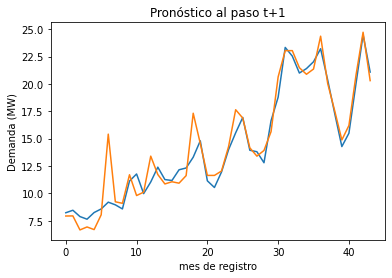

In [87]:
plt.title('Pronóstico al paso t+1')
plt.plot(lista_tplus1)
plt.plot(y[:,0])
plt.xlabel('mes de registro')
plt.ylabel('Demanda (MW)')

Y el pronóstico en el paso t+2 (línea azul) vs el valor real en el paso t+2 (línea naranja)

Text(0, 0.5, 'Demanda (MW)')

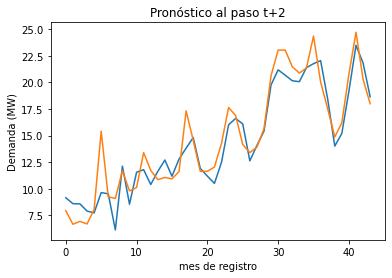

In [88]:
plt.title('Pronóstico al paso t+2')
plt.plot(lista_tplus2)
plt.plot(y[:,1])
plt.xlabel('mes de registro')
plt.ylabel('Demanda (MW)')

Definimos una función simple para calcular el MAPE

In [89]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

Finalmente, evaluamos nuestro modelo calculando el error MAPE para cada paso del pronóstico *(t+1, t+2)* que no esta nada mal.



In [90]:
mape1=mean_absolute_percentage_error(lista_tplus1, y[:,0])
mape2=mean_absolute_percentage_error(lista_tplus2, y[:,1])
print('MAPE tiempo t+1:',mape1)
print('MAPE tiempo t+2:',mape2)

#for x in range(n_steps_out):
#  print(x)
#lista_tplusN=array([])
#lista_tplusN[0]=

MAPE tiempo t+1: 7.629973363390246
MAPE tiempo t+2: 10.610275657985838


3.	Comentar gráficas y errores MAPE para cada uno de los 2 tiempos en adelanto.

Para la gráfica al paso t+1 (mes 4) se observa visualmente que el pronóstico sigue los datos esperados (en este caso los datos de prueba es el total de datos disponibles) dando un error MAPE del 8%.
Conforme se aumenta el horizonte de pronóstico el error MAPE aumenta gradualmente, lo cual apenas se puede apreciar en la gráfica al paso t+2 debido a la cercanía con el error en el paso t+1.

Nota: Dada la naturaleza estocástica del algoritmo o procedimiento de evaluación, los resultados o las diferencias en la precisión numérica pueden variar.